In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Language identification

## 0. Download from twiter dataset

** Skip this part to use pre-downloaded dataset **

In [ ]:
import collections
import tweepy
from tweepy import OAuthHandler

In [4]:

# Put your twitter keys here
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''
 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth)

The download may fail due to different reasons: 
 1. Not valid consumer key
 2. The twitt doens't exitst (already)
 3. Exceeded the limit for 900 messages per 15 min
 
Each of this errors are wrapped under TweepError class

In [34]:
from tweepy import TweepError

In [9]:
# Check if the api is working
id_of_tweet = '1013763276800000'
tweet = api.get_status(id_of_tweet)
print(tweet.text)

Bayern-Remis in Gladbach: Team lethargisch, Trainer tobt: Mario Gomez traf per Kopf, Bastian Schweinsteiger per ... http://bit.ly/9BzI6a


In [268]:
import csv
train_id = open('TwitterLID-groundtruth/ground-truth.trn')
X_ids = []
Y = []
for row in csv.reader(train_id, delimiter=';'):
    x1, y1 = row
    X_ids.append(x1)
    Y.append(y1)

In [166]:
import csv
test_id = open('TwitterLID-groundtruth/ground-truth.tst')
X_ids = []
Y = []
for row in csv.reader(test_id, delimiter=';'):
    x1, y1 = row
    X_ids.append(x1)
    Y.append(y1)

In [ ]:
X_clean = []
Y_clean = []

In [293]:
succeed = False
while not succeed:
    X_raw = []
    prog = 0
    stamp = 2 * 900
    end_stamp = 3 * 900
    failed_inarow = 0
    for i in X_ids[stamp:end_stamp]:
        prog += 1
        if prog%(len(X_ids[stamp:end_stamp])//20) == 0:
            print("Finished " + str(prog/len(X_ids[stamp:end_stamp])) + ' %')
        id_of_tweet = i

        try:
            tweet = api.get_status(id_of_tweet)
            X_raw.append(tweet.text)
            print("Suc")
            failed_inarow = 0
            succeed = True
        except TweepError:
            X_raw.append(None)
            print("Failed")
            failed_inarow += 1
            if failed_inarow > 10:
                print('Wait a little more')
                break

   

Suc
Failed
Suc
Failed
Suc
Suc
Suc
Suc
Failed
Finished 0.05 %
Suc
Suc
Suc
Suc
Failed
Suc
Failed
Suc
Failed
Failed
Finished 0.1 %
Failed
Suc
Failed
Failed
Suc
Failed
Suc
Failed
Suc
Suc
Finished 0.15 %
Failed
Suc
Suc
Suc
Failed
Failed
Failed
Failed
Failed
Suc
Finished 0.2 %
Suc
Suc
Failed
Suc
Failed
Failed
Suc
Failed
Suc
Failed
Finished 0.25 %
Suc
Suc
Suc
Suc
Suc
Suc
Suc
Failed
Failed
Failed
Finished 0.3 %
Failed
Suc
Suc
Suc
Failed
Suc
Suc
Failed
Suc
Failed
Finished 0.35 %
Suc
Suc
Failed
Suc
Suc
Failed
Failed
Failed
Failed
Suc
Finished 0.4 %
Suc
Failed
Failed
Failed
Suc
Failed
Suc
Suc
Failed
Failed
Finished 0.45 %
Failed
Failed
Suc
Failed
Failed
Suc
Suc
Suc
Suc
Failed
Finished 0.5 %
Suc
Failed
Suc
Suc
Suc
Failed
Suc
Suc
Suc
Suc
Finished 0.55 %
Failed
Suc
Suc
Suc
Suc
Suc
Suc
Suc
Failed
Suc
Finished 0.6 %
Suc
Suc
Suc
Failed
Failed
Failed
Suc
Suc
Failed
Suc
Finished 0.65 %
Failed
Failed
Suc
Failed
Suc
Suc
Failed
Failed
Suc
Failed
Finished 0.7 %
Suc
Failed
Suc
Suc
Suc
Failed
Suc
Suc
Suc
Suc
F

In [295]:

for i in range(len(X_raw)):
    if X_raw[i] is not None:
        X_clean.append(X_raw[i])
        Y_clean.append(Y[stamp+i])
str(len(X_clean)) + ' out of ' + str(end_stamp) + ' succeed '

'1389 out of 2700 succeed '

Store downloaded twitts in pickle format

In [297]:
pl.dump((X_clean, Y_clean), file = open('langid.train', 'wb'))

In [247]:
pl.dump((X_clean, Y_clean), file = open('langid.test', 'wb'))

In [104]:
raw_tokens = nltk.word_tokenize(X_clean[0])

# 1. Feature transform

In [25]:
import nltk
from nltk.corpus import stopwords
import pickle as pl
import re
import seaborn as sns

In [33]:
def word2ngrams(text, n=3, exact=True):
    """ Convert sentence into character ngrams. """
    yield [text[i:i+n] for i in range(len(text)-n+1)]

In [31]:
def features(words, n=2):
    feat = {}
    for w in words:
        bi_grams = word2ngrams(w, n=n)
        for inst in bi_grams:
            for bg in inst:
                if bg in feat.keys():
                    feat[bg] +=  1
                else:
                    feat[bg] = 1

    return feat
    

In [29]:
def get_features(text, n_grams = 3, mode ='incl'):
    '''
     Transform sentence into feature vector 
     text: Sentence 
     n_grams: charachter ngram used
     mode: {'incl', None} If incl : Feature vector will conatin ngrams from 1 to n 
    '''
    raw_text =  re.split(' ',text)
    unwanted = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~£'
    raw_text2 = ''
    for k in raw_text:
        # Ignore urls
        if k.startswith('http') or k.startswith('http'):
            continue
        elif k.startswith('@'):     
            continue
        elif k.startswith('#'):
            continue
        else:
            raw_text2 += ' '
            raw_text2 += k
    words_raw = nltk.word_tokenize(raw_text2.lower())
    words = [w for w in words_raw if w not in unwanted]
    feat = word_features(text)
    feat.update(features(words, n=n_grams))
    #words_set = set(words)
    for lang in labels:
        feat[lang+'_stop'] = len(set(words).intersection(set(stopwords.words(lang))))
    if mode == 'incl':
        for i in range(1, n_grams):
            feat.update(features(words, n=i))
    elif mode == 'incl_except': 
         for i in range(2, n_grams):
            feat.update(features(words, n=i))
    return feat

In [2]:
def word_features(terms, inv_terms, text):
    raw_text =  re.split(' ',text)
    unwanted = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~£'
    raw_text2 = ''
    for k in raw_text:
        # Ignore urls
        if k.startswith('http') or k.startswith('http'):
            continue
        elif k.startswith('@'):     
            continue
        elif k.startswith('#'):
            continue
        else:
            raw_text2 += ' '
            raw_text2 += k
    words_raw = nltk.word_tokenize(raw_text2.lower())
    words = [w for w in words_raw if w not in unwanted]
    feat = {}
    for w in words:
        if w in feat.keys():
            feat[w] += 1
        else:
            feat[w] = 1
    return feat

In [28]:
ngrams = 5
mode = 'incl'
stops = 'stop'

In [8]:
(X, Y) =  pl.load(open('langid.train', 'rb'))
train_set = []
prog = 0
for i in range(len(X)):
    train_set.append((word_features(X[i]), Y[i]))
    prog += 1
    if prog%(len(X)//20) == 0:
        print("Finished " + str(100*prog//len(X)) + ' %')

Finished 4 %
Finished 9 %
Finished 14 %
Finished 19 %
Finished 24 %
Finished 29 %
Finished 34 %
Finished 39 %
Finished 44 %
Finished 49 %
Finished 54 %
Finished 59 %
Finished 64 %
Finished 69 %
Finished 74 %
Finished 79 %
Finished 84 %
Finished 89 %
Finished 94 %
Finished 99 %


In [34]:
(X, Y) =  pl.load(open('langid.train', 'rb'))
train_set = []
prog = 0
for i in range(len(X)):
    train_set.append((get_features(X[i], n_grams=ngrams), Y[i]))
    prog += 1
    if prog%(len(X)//20) == 0:
        print("Finished " + str(100*prog//len(X)) + ' %')

Finished 4 %
Finished 9 %
Finished 14 %
Finished 19 %
Finished 24 %
Finished 29 %
Finished 34 %
Finished 39 %
Finished 44 %
Finished 49 %
Finished 54 %
Finished 59 %
Finished 64 %
Finished 69 %
Finished 74 %
Finished 79 %
Finished 84 %
Finished 89 %
Finished 94 %
Finished 99 %


In [9]:
(X, Y) =  pl.load(open('langid.test', 'rb'))
test_set = []
prog = 0
for i in range(len(X)):
    test_set.append((word_features(X[i]), Y[i]))
    prog += 1
    if prog%(len(X)//20) == 0:
        print("Finished " + str(100*prog//len(X)) + ' %')

Finished 5 %
Finished 10 %
Finished 15 %
Finished 20 %
Finished 25 %
Finished 30 %
Finished 35 %
Finished 40 %
Finished 45 %
Finished 50 %
Finished 55 %
Finished 60 %
Finished 65 %
Finished 70 %
Finished 75 %
Finished 80 %
Finished 85 %
Finished 90 %
Finished 95 %
Finished 100 %


In [35]:
(X, Y) =  pl.load(open('langid.test', 'rb'))
test_set = []
prog = 0
for i in range(len(X)):
    test_set.append((get_features(X[i], n_grams=ngrams), Y[i]))
    prog += 1
    if prog%(len(X)//20) == 0:
        print("Finished " + str(100*prog//len(X)) + ' %')

Finished 5 %
Finished 10 %
Finished 15 %
Finished 20 %
Finished 25 %
Finished 30 %
Finished 35 %
Finished 40 %
Finished 45 %
Finished 50 %
Finished 55 %
Finished 60 %
Finished 65 %
Finished 70 %
Finished 75 %
Finished 80 %
Finished 85 %
Finished 90 %
Finished 95 %
Finished 100 %


# 2. Train and classify

In [10]:
classif = 'nb'
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

0.9232558139534883


In [36]:
classif = 'nb'
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

0.9418604651162791


In [46]:
errors = []
i = 0
for (feature, tag) in test_set:
    guess = classifier.classify(feature)
    if guess != tag:
        errors.append( (tag, guess, X[i]))
    i+=1

In [50]:
errors[:]

[('german', 'dutch', 'Morgen!'),
 ('german',
  'english',
  '#7: 81-cm-LCD-TV Panasonic TX-L32U2E Bilddiagonale: 81 cm (32 Zoll) Full HD DVB-C/T und CI+ http://dlvr.it/1YgQV'),
 ('german',
  'dutch',
  'Skandal um Camerons Spin Doctor: R&#252;pel vom Revolverblatt http://t.co/RaLx6XZ'),
 ('german',
  'english',
  'Alternative Musik: #4: Swanlights http://amzn.to/d3AjST #Alternativ #music'),
 ('german', 'english', 'Bei Guy :)'),
 ('german',
  'english',
  '#3: Schall und Wahn (Limited Special Edition) http://ow.ly/16o8jy'),
 ('english',
  'french',
  'RT @slashfilmnews: 24 Officially Canceled http://goo.gl/fb/CCdr'),
 ('english',
  'spanish',
  'I favorited a YouTube video -- Teaser. http://youtu.be/wY4G-SzjXEA?a'),
 ('english', 'dutch', "...'Knackered."),
 ('english',
  'french',
  '#eBay #Stonehaven Combicamp Trailer Tent  http://bit.ly/2skSjl'),
 ('english',
  'german',
  'RT @appnova: Appnova Blog - Paulie Website Launched http://bit.ly/cDJeCB'),
 ('english',
  'french',
  'RT @Burn

'german'

In [551]:
classifier = nltk.DecisionTreeClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

In [22]:
ngrams = 'word'
stops = 'stop'
mode = 'def'

In [37]:
import collections
refsets = collections.defaultdict(set)
testsets = collections.defaultdict(set)
 
true_lab = []
pred_lab = []
for i,(feats, label) in enumerate(test_set):
    true_lab.append(label)
    refsets[label].add(i)
    observed = classifier.classify(feats)
    pred_lab.append(observed)
    testsets[observed].add(i)
labels = list(refsets.keys())

Normalized confusion matrix


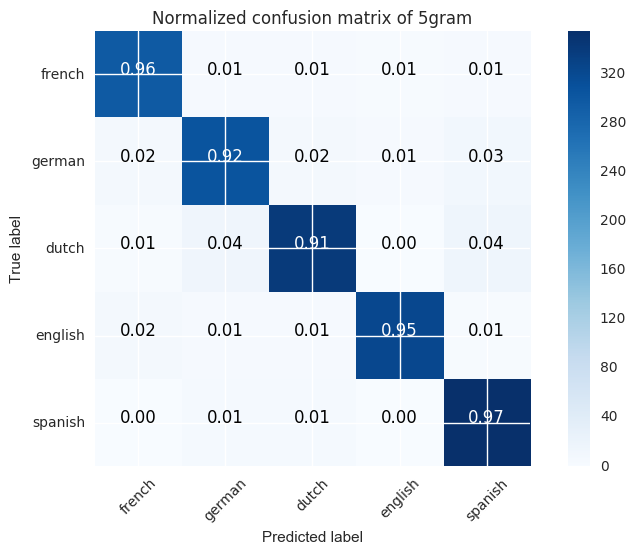

In [38]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')



    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.2f}'.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(pred_lab, true_lab)
np.set_printoptions(precision=2)



# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=True,
                      title='Normalized confusion matrix of {}gram'.format(ngrams))
fig = plt.Figure()
fig.set_canvas(plt.gcf().canvas)
fig.savefig('{}{}{}gram_cm_{}.pdf'.format(stops,mode,ngrams, classif), format='pdf')

plt.show()


F-score: for  french   0.9289617486338798
F-score: for  german   0.966966966966967
F-score: for  dutch   0.954983922829582
F-score: for  english   0.9161676646706588
F-score: for  spanish   0.9441489361702128


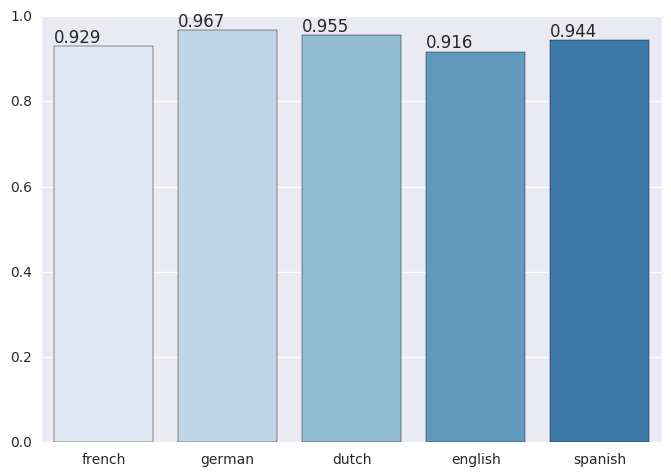

In [39]:

res = []
for lab in labels:
    print('F-score: for ', lab, ' ' , nltk.f_measure(refsets[lab], testsets[lab]))
    res.append(nltk.f_measure(refsets[lab], testsets[lab]))
x= labels
y = res

ax = sns.barplot(x, y, palette=sns.color_palette("Blues"))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x(), height + 0.01, '%1.3f'%(height))
show()
fig1 = ax.get_figure()
fig1.savefig('{}{}{}gram_fs_{}_2.png'.format(stops,mode,ngrams, classif))


In [27]:
k_list = classifier.show_most_informative_features(20)

Most Informative Features
                       a = 1              spanis : german =     45.8 : 1.0
                      en = 1              spanis : german =     35.0 : 1.0
                      la = 1              spanis : englis =     33.5 : 1.0
                     van = 1               dutch : spanis =     33.2 : 1.0
                      to = 1              englis : french =     33.1 : 1.0
                      de = 1              french : german =     32.0 : 1.0
                       à = 1              french : german =     25.2 : 1.0
                      et = 1              french : englis =     24.6 : 1.0
                     for = 1              englis : spanis =     24.0 : 1.0
                      is = 1              englis : german =     23.6 : 1.0
                      no = 1              spanis : french =     22.8 : 1.0
                     the = 1              englis : french =     22.3 : 1.0
                       i = 1              englis : french =     20.7 : 1.0

In [40]:
 classifier.show_most_informative_features(20)

Most Informative Features
                       é = 1              french : german =     50.8 : 1.0
                     ein = 1              german : spanis =     45.7 : 1.0
                     aar = 1               dutch : german =     44.5 : 1.0
                     oor = 1               dutch : french =     42.3 : 1.0
             german_stop = 2              german : spanis =     40.4 : 1.0
                     van = 1               dutch : german =     39.3 : 1.0
                       y = 2              englis : dutch  =     38.2 : 1.0
                     een = 1               dutch : spanis =     37.3 : 1.0
                      th = 2              englis : french =     35.8 : 1.0
                     our = 1              french : spanis =     35.4 : 1.0
                      aa = 1               dutch : french =     33.9 : 1.0
             french_stop = 3              spanis : german =     33.2 : 1.0
                      uf = 1              german : englis =     32.8 : 1.0

In [699]:
def get_features_pruned(text, new_feat_vec, n_grams = 3, mode ='incl'):
    raw_text =  re.split(' ',text)
    unwanted = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~£'
    raw_text2 = ''
    for k in raw_text:
        # Ignore urls
        if k.startswith('http') or k.startswith('http'):
            continue
        elif k.startswith('@'):     
            continue
        elif k.startswith('#'):
            continue
        else:
            raw_text2 += ' '
            raw_text2 += k
    words_raw = nltk.word_tokenize(raw_text2.lower())
    words = [w for w in words_raw if w not in unwanted]
    feat = features(words, n=n_grams)
    #words_set = set(words)
    for lang in labels:
        feat[lang+'_stop'] = len(set(words).intersection(set(stopwords.words(lang))))
    if mode == 'incl':
        for i in range(1, n_grams):
            feat.update(features(words, n=i))
    elif mode == 'incl_except': 
         for i in range(2, n_grams):
            feat.update(features(words, n=i))
    # Pruning
    if len(new_feat_vec)==0:
        return feat
    else:
        pruned_feat = {}
        for k in new_feat_vec:
            if k in feat.keys():
                pruned_feat[k] = feat[k]
            else:
                pruned_feat[k] = 0 

        return pruned_feat

In [859]:
stops = 'stop'
mode = 'incl'
n_grams = 5
classif = 'rfc'
n_feat = 700

In [846]:
k_list = classifier.most_informative_features(n_feat)

In [847]:
new_feat = set()
for i in k_list:
    new_feat.add(i[0])

In [848]:
len(new_feat)

636

In [849]:
(X, Y) =  pl.load(open('langid.train', 'rb'))
train_set = []
prog = 0
for i in range(len(X)):
    train_set.append((get_features_pruned(X[i],new_feat, n_grams=ngrams), Y[i]))
    prog += 1
    if prog%(len(X_clean)//20) == 0:
        print("Finished " + str(100*prog//len(X)) + ' %')

Finished 4 %
Finished 9 %
Finished 14 %
Finished 19 %
Finished 24 %
Finished 29 %
Finished 34 %
Finished 39 %
Finished 44 %
Finished 49 %
Finished 54 %
Finished 59 %
Finished 64 %
Finished 69 %
Finished 74 %
Finished 79 %
Finished 84 %
Finished 89 %
Finished 94 %
Finished 99 %


In [850]:
(X, Y) =  pl.load(open('langid.test', 'rb'))
test_set = []
prog = 0
for i in range(len(X)):
    test_set.append((get_features_pruned(X[i], new_feat, n_grams=ngrams), Y[i]))
    prog += 1
    if prog%(len(X_clean)//20) == 0:
        print("Finished " + str(100*prog//len(X)) + ' %')

Finished 4 %
Finished 8 %
Finished 12 %
Finished 16 %
Finished 20 %
Finished 24 %
Finished 28 %
Finished 32 %
Finished 36 %
Finished 40 %
Finished 44 %
Finished 48 %
Finished 52 %
Finished 56 %
Finished 60 %
Finished 64 %
Finished 68 %
Finished 72 %
Finished 76 %
Finished 80 %
Finished 84 %
Finished 88 %
Finished 92 %
Finished 96 %


In [851]:
from sklearn.naive_bayes import MultinomialNB
X = []
Y = []
for (x,y) in train_set:
    temp = []
    for x1 in x.values():
        temp.append(x1)
    X.append(temp)
    Y.append(y)
    
clf = MultinomialNB()
clf.fit(X, Y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [852]:
X = []
Y = []
for (x,y) in test_set:
    temp = []
    for x1 in x.values():
        temp.append(x1)
    X.append(temp)
    Y.append(y)
    
clf.score(X, Y)

0.92848837209302326

In [853]:
from sklearn.svm import SVC
X = []
Y = []
for (x,y) in train_set:
    temp = []
    for x1 in x.values():
        temp.append(x1)
    X.append(temp)
    Y.append(y)

clf = SVC(kernel = 'rbf')
clf.fit(X, Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [854]:
X = []
Y = []
for (x,y) in test_set:
    temp = []
    for x1 in x.values():
        temp.append(x1)
    X.append(temp)
    Y.append(y)
    
clf.score(X, Y)

0.90930232558139534

In [747]:
from sklearn.ensemble import RandomForestClassifier as rfc

In [858]:

clf = rfc(n_jobs=-1, n_estimators=317, max_depth=None)
X = []
Y = []
for (x,y) in train_set:
    temp = []
    for x1 in x.values():
        temp.append(x1)
    X.append(temp)
    Y.append(y)
    
clf.fit(X, Y)

X = []
Y = []
for (x,y) in test_set:
    temp = []
    for x1 in x.values():
        temp.append(x1)
    X.append(temp)
    Y.append(y)
    
clf.score(X, Y)


0.92209302325581399

In [863]:
refsets = collections.defaultdict(set)
testsets = collections.defaultdict(set)
 
true_lab = []
pred_lab = []
indx = 0
for i in range(len(X)):
    true_lab.append(Y[i])
    refsets[Y[i]].add(indx)
    observed = clf.predict(X[i])
    pred_lab.append(observed)
    testsets[observed[0]].add(indx)
    indx += 1

/usr/local/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local

/usr/local/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local

Normalized confusion matrix


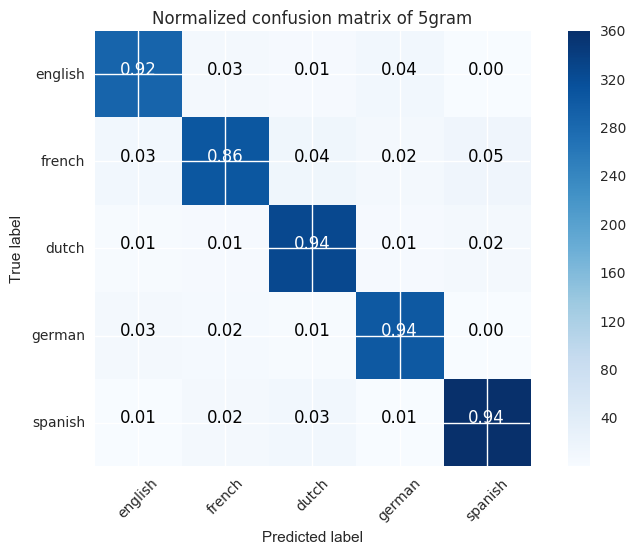

In [860]:

  
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(pred_lab, true_lab)
np.set_printoptions(precision=2)



# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=True,
                      title='Normalized confusion matrix of {}gram'.format(ngrams))
fig = plt.Figure()
fig.set_canvas(plt.gcf().canvas)
fig.savefig('{}{}{}gram_cm_{}{}.png'.format(stops,mode,ngrams, classif, n_feat))

plt.show()

F-score: for  english   0.8911465892597967
F-score: for  french   0.9261363636363636
F-score: for  dutch   0.9201277955271565
F-score: for  german   0.9339477726574501
F-score: for  spanish   0.9376623376623376


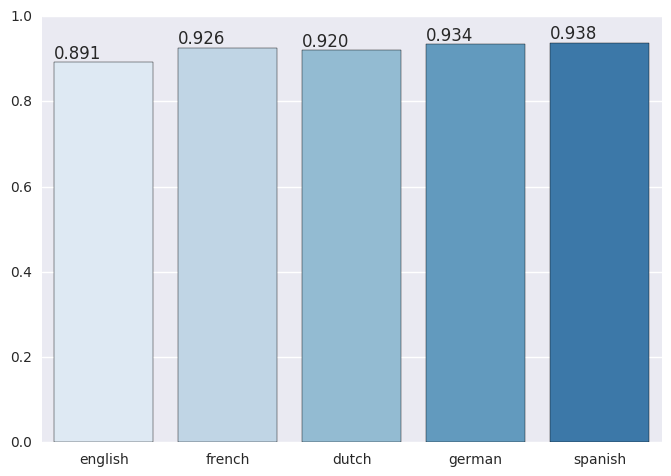

In [867]:
labels = list(refsets.keys())
res = []
for lab in labels:
    print('F-score: for ', lab, ' ' , nltk.f_measure(refsets[lab], testsets[lab]))
    res.append(nltk.f_measure(refsets[lab], testsets[lab]))
x= labels
y = res

ax = sns.barplot(x, y, palette=sns.color_palette("Blues"))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x(), height + 0.01, '%1.3f'%(height))
show()
fig1 = ax.get_figure()
fig1.savefig('{}{}{}gram_fs_{}{}.png'.format(stops,mode,ngrams,classif,n_feat))

